In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/EACL/'
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
!pip install sentencepiece==0.1.94
!pip install transformers==4.0.1
!pip install demoji
!pip install tweet-preprocessor
# !pip install transformers[sentencepiece]

In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
import nltk
import seaborn as sns
import keras
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import SpatialDropout1D
from keras.layers import Conv1D
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.feature_selection import RFE
from keras.callbacks import ModelCheckpoint
import re
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
model_path = 'bert-base-multilingual-cased'
model_path = 'monsoon-nlp/tamillion'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

... OK (Got response in 0.13 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [ ]:
class Dataset():
    def __init__(self, train_data, val_data, test_data):
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        # self.batch_size = batch_size

        self.label_dict = {}
        
        self.count_dic = {}

        # self.trn = Transliterator(source='eng', target='kan', build_lookup=True)

        self.train_df = pd.DataFrame(self.process_data(self.train_data))
        self.val_df = pd.DataFrame(self.process_data(self.val_data))
        self.test_df = pd.DataFrame(self.process_data(self.test_data, test = True))

    def is_english(self, s: str) -> bool:
        if len(re.findall(u'[\u0900-\u097F]', s)) <= 1000:
            return True
        return False

    def process_data(self, data, test = False):
        sentences, labels = [], []
        print(len(data))
        for line in data:
            sentence = line.strip().split('\t')
            if not test:
                label = sentence.pop()
                if label not in self.label_dict:
                    self.label_dict[label] = len(self.label_dict)
                labels.append(self.label_dict[label])
                self.count_dic[label] = self.count_dic.get(label, 0) + 1
            sentence = ' '.join(sentence)
            # emoji_dict = demoji.findall(sentence)

            # # if not self.is_english(sentence):
            # #     print(sentence)
            # #     sentence = self.trn.transform(sentence)
            # #     print(sentence)

            # # sentence = self.trn.transform(sentence)
            # # print(sentence)

            # if len(emoji_dict): 
            #     for emoji, text in emoji_dict.items():
            #         sentence = sentence.replace(emoji, ' '+text+' ')
            #         sentence = ' '.join(sentence.split())
            sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            
            # labels.append(label)
            
        if test: return {'input': sentences}
        return {'input': sentences, 'label': (labels)}

In [ ]:
with open('Dataset/tamil_offensive_full_train.csv', 'r') as f:
    train_data = f.readlines()
with open('Dataset/tamil_offensive_full_dev.csv', 'r') as f:
    val_data = f.readlines()
with open('Dataset/tamil_offensive_full_test.csv', 'r') as f:
    test_data = f.readlines()
data = Dataset(train_data, val_data, test_data)

35139
4388
4392


In [ ]:
data.train_df.input

0                        movie vara level la Erika poguthu
1        I love Ajith Kumar Vivegam movie inki mjy bht ...
2                Padam nalla comedy padama irukum polaye..
3        karthick subburaj anne .... intha padam vetri ...
4        கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁
                               ...                        
35134    Trending number #2 idhukku nammalam karanamnu ...
35135    Movie script super, athuvum HIP HOP Tamizha mu...
35136                         Just 3k likes for 300k likes
35137                            Aaloo le lo. Kanda le lo.
35138    நாமக்கல் மாவட்டம் வன்னியர் சார்பாக திரௌபதி படம...
Name: input, Length: 35139, dtype: object

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 64000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 128
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(data.train_df.input)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 76267 unique tokens.


In [ ]:
X_train = tokenizer.texts_to_sequences(data.train_df.input.values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

X_val = tokenizer.texts_to_sequences(data.val_df.input.values)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_val.shape)

X_test = tokenizer.texts_to_sequences(data.test_df.input.values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (35139, 128)
Shape of data tensor: (4388, 128)
Shape of data tensor: (4392, 128)


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8135351879604228692
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13812936256
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16392267008288941937
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
Y_train = pd.get_dummies(data.train_df.label).values
print('Shape of label tensor:', Y_train.shape)

Y_val = pd.get_dummies(data.val_df.label).values
print('Shape of label tensor:', Y_val.shape)

Shape of label tensor: (35139, 6)
Shape of label tensor: (4388, 6)


In [ ]:
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
from sklearn.metrics import f1_score, accuracy_score
# def f1(ytrue, ypred):
#     return f1_score(get_predicted(np.array(ytrue)), get_predicted(np.array(ypred)), average = 'weighted')

In [ ]:
from keras import backend as K
def f1(true, pred): #shapes (batch, 4)

    #for metrics include these two lines, for loss, don't include them
    #these are meant to round 'pred' to exactly zeros and ones
    #predLabels = K.argmax(pred, axis=-1)
    #pred = K.one_hot(predLabels, 4) 


    ground_positives = K.sum(true, axis=0)       # = TP + FN
    pred_positives = K.sum(pred, axis=0)         # = TP + FP
    true_positives = K.sum(true * pred, axis=0)  # = TP
        #all with shape (4,)

    precision = (true_positives + K.epsilon()) / (pred_positives + K.epsilon()) 
    recall = (true_positives + K.epsilon()) / (ground_positives + K.epsilon()) 
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #not sure if this last epsilon is necessary
        #matematically not, but maybe to avoid computational instability
        #still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)


    return weighted_f1 #for metrics, return only 'weighted_f1

In [ ]:
mc = ModelCheckpoint('model_tam_1.h5', monitor='val_f1', mode='max', save_best_only=True)
cb_list = mc

In [ ]:
from tensorflow.keras import layers

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(layers.Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=4, batch_size=32, callbacks = cb_list)
# Final evaluation of the model
model_pred_train = model.predict(X_train)
model_pred_test = model.predict(X_val)
# print(classification_report(test_labels,model_pred_test))
print('LSTM Recurrent Neural Network baseline: ' + str(roc_auc_score(Y_train, model_pred_train)))
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(Y_val, model_pred_test)))

Epoch 1/4
1099/1099 [==============================] - 1196s 1s/step - loss: 0.8946 - f1: 0.5940 - val_loss: 0.7014 - val_f1: 0.6769
Epoch 2/4
1099/1099 [==============================] - 1234s 1s/step - loss: 0.5185 - f1: 0.7511 - val_loss: 0.7403 - val_f1: 0.7064
Epoch 3/4
1099/1099 [==============================] - 1226s 1s/step - loss: 0.2927 - f1: 0.8539 - val_loss: 0.9111 - val_f1: 0.7144
Epoch 4/4
1099/1099 [==============================] - 1208s 1s/step - loss: 0.1548 - f1: 0.9221 - val_loss: 1.0420 - val_f1: 0.7201
LSTM Recurrent Neural Network baseline: 0.9971665479462112
LSTM Recurrent Neural Network: 0.8166860213876218


In [ ]:
model = keras.models.load_model('best_model_tam.h5')

In [ ]:

model_pred_train = model.predict(X_train)
model_pred_test = model.predict(X_val)
f1 = f1_score(get_predicted(Y_train), get_predicted(model_pred_train), average = 'weighted')
acc = accuracy_score(get_predicted(Y_train), get_predicted(model_pred_train))
print(f1, acc)

0.9811901687627629 0.9813597427359914


In [ ]:
f1 = f1_score(get_predicted(Y_val), get_predicted(model_pred_test), average = 'weighted')
f1

0.7334143882178368

In [ ]:
acc = accuracy_score(get_predicted(Y_val), get_predicted(model_pred_test))
print(f1, acc)

0.7334143882178368 0.7502278942570647


In [ ]:
for x in get_predicted(Y_train): print(x)

In [ ]:
f1

0.9723194546009677

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=5, batch_size=32)

In [ ]:
_, ypred, ytest = evaluate(data.val_dataloader, model)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

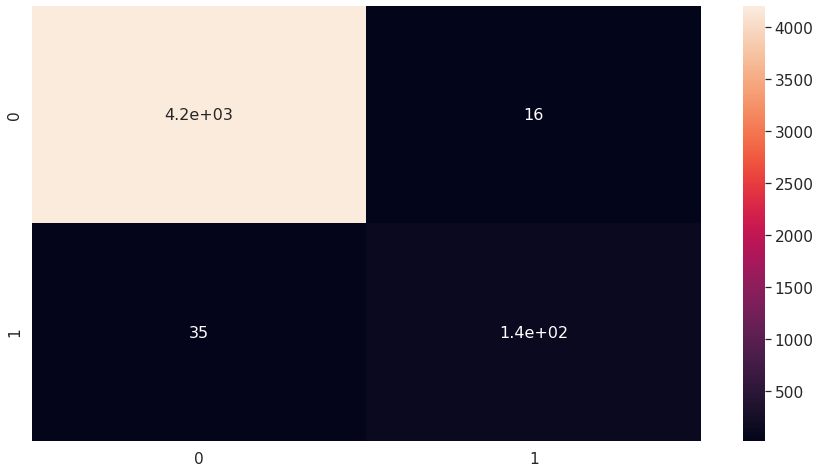

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
train(data.train_dataloader, data.val_dataloader, model, 'tamil_mal.pt')